In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data = data.drop(columns=['Name'])
    categorical_cols = ['Sex', 'Pclass']
    data = pd.get_dummies(data, columns=categorical_cols)
    numeric_cols = ['Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
    for col in numeric_cols:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

In [5]:
# Splitting data for cross-validation
def stratified_k_fold(data, k=10):
    data = data.sample(frac=1).reset_index(drop=True)
    folds = []
    targets = data['Survived']
    target_classes = targets.unique()

    for i in range(k):
        fold = pd.concat([data[targets == target].iloc[i::k] for target in target_classes])
        folds.append(fold)
    return folds

In [7]:
class DecisionTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        if len(y.unique()) == 1 or depth >= self.max_depth:
            return {'label': y.mode()[0]}
        best_feature, best_threshold = self._choose_best_feature(X, y)
        if best_feature is None:
            return {'label': y.mode()[0]}
        left_idx = X[best_feature] <= best_threshold
        right_idx = X[best_feature] > best_threshold
        left_tree = self._build_tree(X[left_idx], y[left_idx], depth+1)
        right_tree = self._build_tree(X[right_idx], y[right_idx], depth+1)
        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}

    def _choose_best_feature(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None
        for feature in X.columns:
            sorted_values = np.sort(X[feature].unique())
            possible_thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2
            for threshold in possible_thresholds:
                left_y = y[X[feature] <= threshold]
                right_y = y[X[feature] > threshold]
                if left_y.empty or right_y.empty:
                    continue
                gain = self._information_gain(y, left_y, right_y)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _information_gain(self, y, left_y, right_y):
        def entropy(s):
            counts = np.bincount(s)
            probabilities = counts / len(s)
            return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        total_entropy = entropy(y)
        left_entropy = entropy(left_y)
        right_entropy = entropy(right_y)
        return total_entropy - (len(left_y) / len(y) * left_entropy + len(right_y) / len(y) * right_entropy)

    def predict(self, X):
        predictions = X.apply(self._predict_row, axis=1)
        return predictions

    def _predict_row(self, row):
        node = self.tree
        while 'label' not in node:
            node = node['left'] if row[node['feature']] <= node['threshold'] else node['right']
        return node['label']

In [9]:
def multiple_iterations(data, depth, iterations=100):
    accuracies = []
    f1_scores = []
    for _ in range(iterations):
        folds = stratified_k_fold(data)
        fold_accuracies = []
        fold_f1_scores = []
        for i in range(len(folds)):
            train_folds = folds[:i] + folds[i+1:]
            test_fold = folds[i]
            train_data = pd.concat(train_folds)
            test_data = test_fold
            X_train, y_train = train_data.drop(columns=['Survived'], axis=1), train_data['Survived']
            X_test, y_test = test_data.drop(columns=['Survived'], axis=1), test_data['Survived']
            tree = DecisionTree(max_depth=depth)
            tree.fit(X_train, y_train)
            predictions = tree.predict(X_test)
            fold_accuracies.append(accuracy_score(y_test, predictions))
            fold_f1_scores.append(f1_score(y_test, predictions))
        accuracies.append(np.mean(fold_accuracies))
        f1_scores.append(np.mean(fold_f1_scores))


    print(f"Average Accuracy: {np.mean(accuracies):.4f}, Std Dev: {np.std(accuracies):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}, Std Dev: {np.std(f1_scores):.4f}")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(accuracies, bins=10, color='lightblue')
    plt.title('Histogram of Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.hist(f1_scores, bins=10, color='lightblue')
    plt.title('Histogram of F1 Scores')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Average Accuracy: 0.8261, Std Dev: 0.0036
Average F1 Score: 0.7592, Std Dev: 0.0053


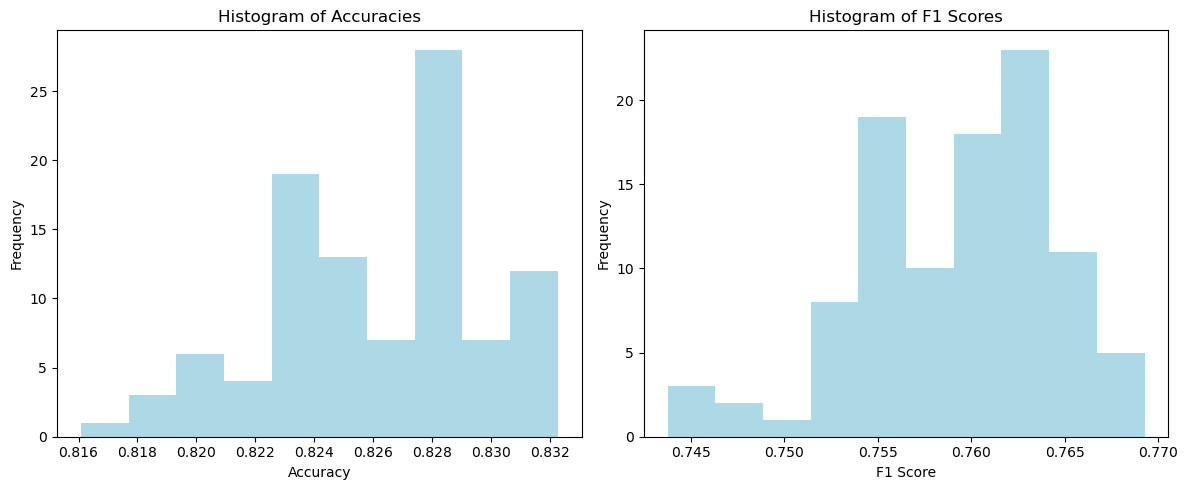

In [12]:
if __name__ == "__main__":
    filepath = 'titanic.csv'
    data = load_and_preprocess_data(filepath)
    # print(data)
    depth = 5
    multiple_iterations(data, depth)